### 1. Create Supervisor Agent

- create react prebuilt and make the supervisor agent and worker agents using langgraph react prebuilt.

- "Command" It can be useful to combine control flow (edges) and state updates (nodes). For example, you might want to BOTH perform state updates AND decide which node to go to next in the SAME node. 

In [2]:
# connect with gemini api
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

In [3]:
# initialize llm chat model
from langchain_google_genai import ChatGoogleGenerativeAI
from google.genai.types import GenerateContentConfig


system_instruction = """
                        You are a phone-agent assistant.  
                        
                        Keep all messages very short—just a single question or one answer.  
                        
                        Act as if you’re on a live call: no long explanations or chit-chat.  
                        
                        Always reference prior chat context and stay aligned with the conversation.  
                        
                    """

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-preview-05-20",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    config=GenerateContentConfig(
        system_instruction=system_instruction,
    ),
    # other params...
)

### 2. Create tools for doctor appointment booking | rescheduling | cancel

In [142]:
from langgraph.types import Command
from langgraph.prebuilt.chat_agent_executor import AgentState
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage,ToolMessage
from langchain_core.messages import ToolMessage 
from typing_extensions import Annotated
from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, MessagesState, START, END

# Doctor appointment tools
def book_appointment(doctor_name: str, date: str, time: str):
    """Book a new doctor appointment"""
    return f"Appointment booked with Dr. {doctor_name} on {date} at {time}."

def reschedule_appointment(appointment_id: str, new_date: str, new_time: str):
    """Reschedule an existing doctor appointment"""
    return f"Appointment {appointment_id} rescheduled to {new_date} at {new_time}."

def cancel_appointment(appointment_id: str):
    """Cancel an existing doctor appointment"""
    return f"Appointment {appointment_id} has been cancelled."

def search_doctor(specialization: str = "", location: str = ""):
    """Search for doctors by specialization and/or location"""
    return f"Found doctors matching specialization='{specialization}' and location='{location}'."

def search_appointment(patient_id: str = "", doctor_name: str = "", date: str = ""):
    """Search for existing appointments by patient, doctor, or date"""
    return f"Found appointments for patient_id='{patient_id}', doctor='{doctor_name}', date='{date}'."

def complete_task(state: Annotated[AgentState, InjectedState]):
    """Call when the given task is fully completed"""
    last_message = state["messages"][-1]
    tool_calls = last_message.tool_calls[0]
    tool_call_id = tool_calls['id']
    return Command(
        goto=END,
        update={"messages": [ToolMessage("success",tool_call_id=tool_call_id),], "dialog_state":"pop"}
    )

### 3. Agent for new appointment booking use prebuilt

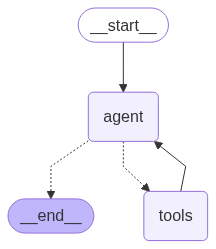

In [143]:
# 
from IPython.display import Image, display
from langgraph.prebuilt import create_react_agent, InjectedState

tools = [search_doctor, book_appointment, complete_task]
new_booking_assistant_node = create_react_agent(
    model=llm,
    tools=tools,
    prompt="You are a new appointment booking assistant.before booking an appointment,You should first search for a doctor. If doctor is confirmed. Then you can book an appointment.If all task is completed call the complete_task.",
    name="new_booking_assistant"
)

# Show the agent
display(Image(new_booking_assistant_node.get_graph().draw_mermaid_png()))

In [144]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage

config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="I want to book with dr.Alice. at 2pm 16 july")]
events = new_booking_assistant_node.stream({"messages": messages},
                                      config,
                                      stream_mode="values",)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

I want to book with dr.Alice. at 2pm 16 july
================================== Ai Message ==================================
Name: new_booking_assistant

Could you please specify the year for July 16? Also, have you already searched for Dr. Alice, or would you like me to proceed with booking the appointment?


### 4. Agent for cancel appointment booking use prebuilt

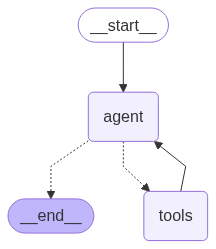

In [145]:
# make a sub agent that specialized for cancel an appointment
from IPython.display import Image, display
from langgraph.prebuilt import create_react_agent, InjectedState

tools = [search_appointment, cancel_appointment, complete_task]
cancel_booking_assistant_node = create_react_agent(
    model=llm,
    tools=tools,
    prompt="You are a cancel appointment booking assistant.before cancel an appointment, You should search for an appointment. If all task is completed call the complete_task.",
    name="cancel_booking_assistant"
)

# Show the agent
display(Image(cancel_booking_assistant_node.get_graph().draw_mermaid_png()))

In [146]:
# simple router with structured output
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage,ToolMessage

config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="I want to cancel my appointment")]
events = cancel_booking_assistant_node.stream({"messages": messages},
                                      config,
                                      stream_mode="values",)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

I want to cancel my appointment
================================== Ai Message ==================================
Name: cancel_booking_assistant

Do you have the appointment ID, patient ID, doctor name, or date of the appointment?


In [147]:
messages = [HumanMessage(content="yea my appointment id is 2")]
events = cancel_booking_assistant_node.stream({"messages": messages},
                                      config,
                                      stream_mode="values",)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

yea my appointment id is 2
================================== Ai Message ==================================
Name: cancel_booking_assistant

To confirm the appointment before cancellation, could you please provide the date of the appointment, the doctor's name, or your patient ID?


### 5. make a supervisor Tools are used to routing

Router tool for speific agent handover.

In [148]:
from pydantic import BaseModel, Field
from typing import Literal

class cancel_booking_assistant(BaseModel):
    """If user needs to cancel an appointment"""
    reason: str = Field(description="Reason why the request should be routed")

class new_booking_assistant(BaseModel):
    """If user needs to book a new appointment with a doctor"""
    reason: str = Field(description="Reason why the request should be routed")

In [149]:
from typing import Literal
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command

llm_with_tools =llm.bind_tools([cancel_booking_assistant, new_booking_assistant])

def primary_agent(state: MessagesState) -> Command[Literal["cancel_booking_assistant", "new_booking_assistant"]]:
    
    response = llm_with_tools.invoke(state["messages"])
    
    print(response)
    
    # if the router think to navigate to agent
    if hasattr(response, "tool_call") or hasattr(response, "tool_calls"):
        # get the tool name and route to relavant node
        tool_call = response.tool_calls[0]
        tool_name = tool_call["name"]
        
        # route to relavant node
        return Command(
            # next node to be executed next
            goto=tool_name,
            # state update 
            update={"messages": []}
        )
    
    return {"messages": []}


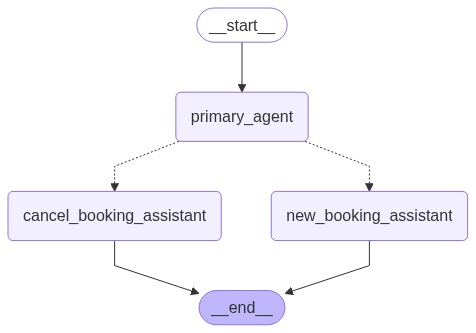

In [150]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
# Create the graph
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("primary_agent", primary_agent)
graph_builder.add_node("new_booking_assistant", new_booking_assistant_node)
graph_builder.add_node("cancel_booking_assistant", cancel_booking_assistant_node)

graph_builder.set_entry_point("primary_agent")
graph = graph_builder.compile(checkpointer=memory)

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [151]:
from langfuse import Langfuse
import os

langfuse = Langfuse(
  secret_key="sk-lf-dc4b0843-f2de-4bd8-aea0-f852d023b234",
  public_key="pk-lf-95bfeee2-5ed3-4ea7-ae8e-a84c0e1d8277",
  host="https://cloud.langfuse.com"
)

# get keys for your project from https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-95bfeee2-5ed3-4ea7-ae8e-a84c0e1d8277"
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-dc4b0843-f2de-4bd8-aea0-f852d023b234"

from langfuse.callback import CallbackHandler

# Initialize Langfuse CallbackHandler for Langchain (tracing)
langfuse_handler = CallbackHandler()

In [152]:
config = {"configurable": {"thread_id": "1"}, "callbacks": [langfuse_handler]}
messages = [HumanMessage(content="I want to cancel my appointment")]
events = graph.stream({"messages": messages},
                                      config,
                                      stream_mode="values",)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

I want to cancel my appointment
content='' additional_kwargs={'function_call': {'name': 'cancel_booking_assistant', 'arguments': '{"reason": "User wants to cancel an appointment"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-05-20', 'safety_ratings': []} id='run--658efa99-2c33-4ba0-9678-4e62d1dcfa5e-0' tool_calls=[{'name': 'cancel_booking_assistant', 'args': {'reason': 'User wants to cancel an appointment'}, 'id': '4e01d121-760c-4ca9-a18b-db54af5ad31a', 'type': 'tool_call'}] usage_metadata={'input_tokens': 105, 'output_tokens': 22, 'total_tokens': 173, 'input_token_details': {'cache_read': 0}}
================================ Human Message =================================

I want to cancel my appointment
================================== Ai Message ==================================
Name: cance

In [153]:
messages = [HumanMessage(content="my appointment id is 2")]
events = graph.stream({"messages": messages},
                                      config,
                                      stream_mode="values",)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

my appointment id is 2
content='' additional_kwargs={'function_call': {'name': 'cancel_booking_assistant', 'arguments': '{"reason": "User wants to cancel an appointment with ID 2."}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-05-20', 'safety_ratings': []} id='run--57758f67-0989-4771-afd1-a2df65a3381b-0' tool_calls=[{'name': 'cancel_booking_assistant', 'args': {'reason': 'User wants to cancel an appointment with ID 2.'}, 'id': '12919f4b-4634-4d96-89dd-43c22bb5f863', 'type': 'tool_call'}] usage_metadata={'input_tokens': 132, 'output_tokens': 26, 'total_tokens': 364, 'input_token_details': {'cache_read': 0}}
================================ Human Message =================================

my appointment id is 2
================================== Ai Message ==================================
Name: c

### 6. Add user state to route back to the relavant node when conversation start 

When again start with the primary router instead of using current agent.

Make a state managment system navigate back to the current state of the agent.

In [136]:
from typing import Annotated, Literal, Optional
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages

# this method is used to update the current state of the graph
# this state is updated when the entry of the sub agent and when leave the skill state is updated
def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]

# state of the graph
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    dialog_state: Annotated[
        list[
            Literal[
                "primary_agent",
                "new_booking_assistant",
                "cancel_booking_assistant",
            ]
        ],
        update_dialog_stack,
    ]

In [137]:
from typing import Annotated, Literal, Optional
from langgraph.types import Command
# condition to route again to current work flow from the start
# this condition is checked at the user info node and route to correct node
def route_to_workflow(
    state: State,
) -> Command[Literal[
    "primary_agent",
    "new_booking_assistant",
    "cancel_booking_assistant",
]]:
    """If we are in a delegated state, route directly to the appropriate assistant."""
    dialog_state = state.get("dialog_state")
    print("Current dialog State is : ",dialog_state)
    if not dialog_state:
        dialog_state = "primary_agent"
    print("debug: ",dialog_state[-1])
    dialog_state = dialog_state[-1]
    return Command(
        # state update
        update={"dialog_state":None},
        # control flow
        goto=dialog_state
    )

In [138]:
# define primary node slightly different and add current state and update that state
def primary_agent(state: State) -> Command[Literal["cancel_booking_assistant", "new_booking_assistant"]]:
    
    response = llm_with_tools.invoke(state["messages"])
    
    print(response)
    
    # if the router think to navigate to agent
    if hasattr(response, "tool_call") or hasattr(response, "tool_calls"):
        # get the tool name and route to relavant node
        tool_call = response.tool_calls[0]
        tool_name = tool_call["name"]
        
        # route to relavant node
        return Command(
            # next node to be executed next
            goto=tool_name,
            # state update 
            update={"messages": [], "dialog_state":tool_name}
        )
    
    return {"messages": [], "dialog_state":None}

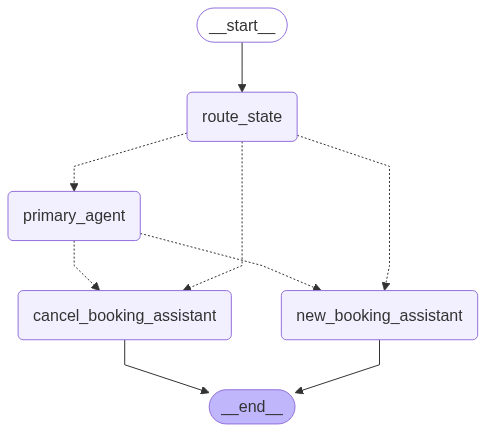

In [139]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
# Create the graph
graph_builder = StateGraph(State)
graph_builder.add_node("route_state", route_to_workflow)
graph_builder.add_node("primary_agent", primary_agent)
graph_builder.add_node("new_booking_assistant", new_booking_assistant_node)
graph_builder.add_node("cancel_booking_assistant", cancel_booking_assistant_node)

graph_builder.set_entry_point("route_state")
graph_builder.add_edge("route_state" ,"primary_agent")
graph = graph_builder.compile(checkpointer=memory)

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))
# This requires some extra dependencies and is optional
    

In [140]:
config = {"configurable": {"thread_id": "1"}, "callbacks": [langfuse_handler]}
messages = [HumanMessage(content="I want to cancel my appointment")]
events = graph.stream({"messages": messages},
                                      config,
                                      stream_mode="values",)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

I want to cancel my appointment
Current dialog State is :  []
debug:  t
================================ Human Message =================================

I want to cancel my appointment
content='' additional_kwargs={'function_call': {'name': 'cancel_booking_assistant', 'arguments': '{"reason": "User wants to cancel an appointment"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-05-20', 'safety_ratings': []} id='run--195943a2-0ec8-43c2-99ac-c10637d94aec-0' tool_calls=[{'name': 'cancel_booking_assistant', 'args': {'reason': 'User wants to cancel an appointment'}, 'id': '127d45e7-17ec-4c87-9f96-c7455b4d8f4e', 'type': 'tool_call'}] usage_metadata={'input_tokens': 105, 'output_tokens': 22, 'total_tokens': 173, 'input_token_details': {'cache_read': 0}}
================================ Human Message =====

In [154]:
config = {"configurable": {"thread_id": "1"}, "callbacks": [langfuse_handler]}
messages = [HumanMessage(content="i want to book an new appointment")]
events = graph.stream({"messages": messages},
                                      config,
                                      stream_mode="values",)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

i want to book an new appointment
content='' additional_kwargs={'function_call': {'name': 'new_booking_assistant', 'arguments': '{"reason": "User wants to book a new appointment"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-05-20', 'safety_ratings': []} id='run--0abedb03-b974-4c87-8e70-839c409f7682-0' tool_calls=[{'name': 'new_booking_assistant', 'args': {'reason': 'User wants to book a new appointment'}, 'id': '0b522e2e-e2a3-411d-8a22-83715a8eaf3e', 'type': 'tool_call'}] usage_metadata={'input_tokens': 210, 'output_tokens': 23, 'total_tokens': 281, 'input_token_details': {'cache_read': 0}}
================================ Human Message =================================

i want to book an new appointment
================================== Ai Message ==================================
Name: new_b

In [155]:
config = {"configurable": {"thread_id": "1"}, "callbacks": [langfuse_handler]}
messages = [HumanMessage(content="i want with dr.Janith")]
events = graph.stream({"messages": messages},
                                      config,
                                      stream_mode="values",)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

i want with dr.Janith
content='' additional_kwargs={'function_call': {'name': 'new_booking_assistant', 'arguments': '{"reason": "User wants to book a new appointment with Dr. Janith."}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-05-20', 'safety_ratings': []} id='run--887c02ad-6d63-40fd-bb20-cf68ba42cd27-0' tool_calls=[{'name': 'new_booking_assistant', 'args': {'reason': 'User wants to book a new appointment with Dr. Janith.'}, 'id': '0f6b4545-b561-4601-adf4-617e5f4535c9', 'type': 'tool_call'}] usage_metadata={'input_tokens': 240, 'output_tokens': 28, 'total_tokens': 337, 'input_token_details': {'cache_read': 0}}
================================ Human Message =================================

i want with dr.Janith
================================== Ai Message ==================================
N

In [156]:
config = {"configurable": {"thread_id": "1"}, "callbacks": [langfuse_handler]}
messages = [HumanMessage(content="i want 24th july 2025")]
events = graph.stream({"messages": messages},
                                      config,
                                      stream_mode="values",)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

i want 24th july 2025
content='' additional_kwargs={'function_call': {'name': 'new_booking_assistant', 'arguments': '{"reason": "User wants to book a new appointment with Dr. Janith on 24th July 2025."}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-05-20', 'safety_ratings': []} id='run--1b2d2315-4c5a-4439-9188-d28f46fc8652-0' tool_calls=[{'name': 'new_booking_assistant', 'args': {'reason': 'User wants to book a new appointment with Dr. Janith on 24th July 2025.'}, 'id': '74130cd3-7445-4791-9b1e-8a0dc3ebba38', 'type': 'tool_call'}] usage_metadata={'input_tokens': 273, 'output_tokens': 39, 'total_tokens': 389, 'input_token_details': {'cache_read': 0}}
================================ Human Message =================================

i want 24th july 2025
================================== Ai Message 

In [157]:
config = {"configurable": {"thread_id": "1"}, "callbacks": [langfuse_handler]}
messages = [HumanMessage(content="at 2pm")]
events = graph.stream({"messages": messages},
                                      config,
                                      stream_mode="values",)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

at 2pm
content='' additional_kwargs={'function_call': {'name': 'new_booking_assistant', 'arguments': '{"reason": "User wants to book a new appointment with Dr. Janith on July 24th, 2025, at 2 PM."}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-05-20', 'safety_ratings': []} id='run--f5f6c998-0b1a-4439-bac9-a9e325ec4c4d-0' tool_calls=[{'name': 'new_booking_assistant', 'args': {'reason': 'User wants to book a new appointment with Dr. Janith on July 24th, 2025, at 2 PM.'}, 'id': 'd58b0199-d739-476b-a944-de1cd05c4039', 'type': 'tool_call'}] usage_metadata={'input_tokens': 306, 'output_tokens': 45, 'total_tokens': 416, 'input_token_details': {'cache_read': 0}}
================================ Human Message =================================

at 2pm
================================== Ai Message ==========

In [160]:
config = {"configurable": {"thread_id": "2"}, "callbacks": [langfuse_handler]}
messages = [HumanMessage(content="I want to cancel my appointment, appointment id is 5")]
events = graph.stream({"messages": messages},
                                      config,
                                      stream_mode="values",)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

I want to cancel my appointment, appointment id is 5
content='' additional_kwargs={'function_call': {'name': 'cancel_booking_assistant', 'arguments': '{"reason": "User wants to cancel the appointment"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-05-20', 'safety_ratings': []} id='run--18e52201-0039-44a2-9b03-40594e3685f6-0' tool_calls=[{'name': 'cancel_booking_assistant', 'args': {'reason': 'User wants to cancel the appointment'}, 'id': 'fe32292b-4703-4d84-bb19-8fc7aac04b42', 'type': 'tool_call'}] usage_metadata={'input_tokens': 111, 'output_tokens': 22, 'total_tokens': 219, 'input_token_details': {'cache_read': 0}}
================================ Human Message =================================

I want to cancel my appointment, appointment id is 5
================================== Ai Message ==